## Visualize results NARMAX experiments

In [80]:
using JLD
using DataFrames
using Statistics
using StatsPlots
using LaTeXStrings
using Plots
pyplot();

include("visualization.jl");

In [37]:
alpha = 0.1
linewidth = 2;
styles = [:solid, :dash, :dot, :dashdot];

### Experiment

In [38]:
# Signal lengths
NT = [50, 100, 200, 400, 800, 1600, 3200, 6400, 12800]
NE = length(NT)

deg = 3
order = 10

results = zeros(NE,4)
diffs = zeros(NE,2)
for (i,n) in enumerate(NT)

    # Load
    RMS_FEM = load("results/results-NARMAX_FEM_M"*string(order)*"_degree"*string(deg)*"_S"*string(n)*".jld", "RMS")
    RMS_RLS = load("results/results-NARMAX_RLS_M"*string(order)*"_degree"*string(deg)*"_S"*string(n)*".jld", "RMS")
    
    ΔRMS = RMS_RLS .- RMS_FEM
    
    # Filter infinities and NaNs
    RMS_FEM = filter(!isinf, filter(!isnan, RMS_FEM))
    RMS_RLS = filter(!isinf, filter(!isnan, RMS_RLS))
    ΔRMS = filter(!isinf, filter(!isnan, ΔRMS))
    
    # Populate RMS array
    results[i,1] = tmean(RMS_FEM, tr=0.05)
    results[i,2] = trimse(RMS_FEM, tr=0.05)
    results[i,3] = tmean(RMS_RLS, tr=0.05)
    results[i,4] = trimse(RMS_RLS, tr=0.05)
    
    # Populate RMS difference array
    diffs[i,1] = tmean(ΔRMS, tr=0.05)
    diffs[i,2] = trimse(ΔRMS, tr=0.05)
    
end

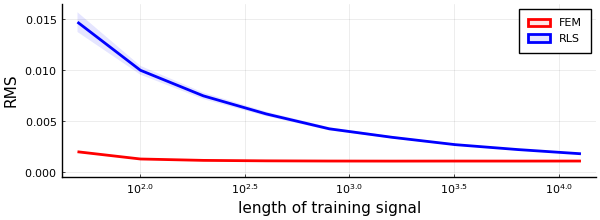

In [39]:
p6 = plot(NT, results[:,1], 
          ribbon=[results[:,2] results[:,2]], 
          color="red", 
          label="FEM", 
          xscale=:log10,
#           yscale=:log10,
          ylims=[0.00, 0.016],
          linewidth=linewidth,
          fillalpha=alpha,
          xlabel="length of training signal",
          ylabel="RMS",
          size=(600,220))
plot!(NT, results[:,3], 
     ribbon=[results[:,4] results[:,4]], 
     color="blue", 
     linewidth=linewidth,
     fillalpha=alpha,
     label="RLS")

In [40]:
savefig(p6, "figures/NARMAX-RMS_deg"*string(deg)*"_order"*string(order)*".png")

### Experiment: varying model orders

In [67]:
# Signal lengths
NT = [50, 100, 200, 400, 800, 1600, 3200]
NE = length(NT)

deg = 3
orders = [4,7,10]
ND = length(orders)

results = zeros(4, NE, ND)
diffs = zeros(2, NE, ND)
for (j,d) in enumerate(orders)
    for (i,n) in enumerate(NT)

        RMS_FEM = load("results/results-NARMAX_FEM_M"*string(d)*"_degree"*string(deg)*"_S"*string(n)*".jld", "RMS")
        RMS_RLS = load("results/results-NARMAX_RLS_M"*string(d)*"_degree"*string(deg)*"_S"*string(n)*".jld", "RMS")
        ΔRMS = RMS_FEM .- RMS_RLS

        # Filter infinities and NaNs
        RMS_FEM = filter(!isinf, filter(!isnan, RMS_FEM))
        RMS_RLS = filter(!isinf, filter(!isnan, RMS_RLS))
        ΔRMS = filter(!isinf, filter(!isnan, ΔRMS))

        results[1,i,j] = tmean(RMS_FEM, tr=0.05)
        results[2,i,j] = trimse(RMS_FEM, tr=0.05)
        results[3,i,j] = tmean(RMS_RLS, tr=0.05)
        results[4,i,j] = trimse(RMS_RLS, tr=0.05)
        
        diffs[1,i,j] = tmean(ΔRMS, tr=0.05)
        diffs[2,i,j] = trimse(ΔRMS, tr=0.05)
    end
end

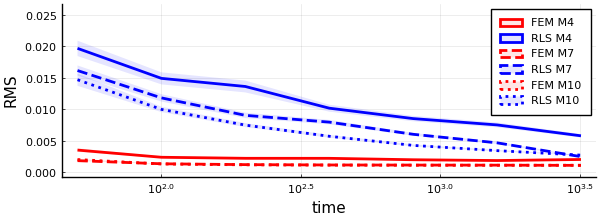

In [68]:
p7 = plot(size=(600,220), legend=:topright)
for (ii,ord) in enumerate(orders)

    plot!(NT, results[1,:,ii], 
          ribbon=[results[2,:,ii] results[2,:,ii]], 
          color="red", 
          label="FEM M"*string(ord), 
          linestyle=styles[ii],
          fillalpha=alpha,
          linewidth=linewidth,
          xlabel="time",
          ylabel="RMS",
          xscale=:log10,
#           yscale=:log10,
          ylims=[0.0, 0.026]
          )
    plot!(NT, results[3,:,ii], 
          ribbon=[results[4,:,ii] results[4,:,ii]], 
          color="blue", 
          linestyle=styles[ii],
          fillalpha=alpha,
          linewidth=linewidth,
          label="RLS M"*string(ord))
end
plot!()

In [69]:
savefig(p7, "figures/NARMAX-RMS_deg"*string(deg)*"_vary-model-orders.png")

In [70]:
# Signal lengths
NT = 200
deg = 3
orders = [4,7,10]
ND = length(orders)

free_energies = zeros(NT, ND)
for (j,d) in enumerate(orders)
    F = load("results/FE-NARMAX_FEM_M"*string(d)*"_degree"*string(deg)*"_S"*string(NT)*".jld", "FE")
    free_energies[:,j] = F[2:end,end]
end

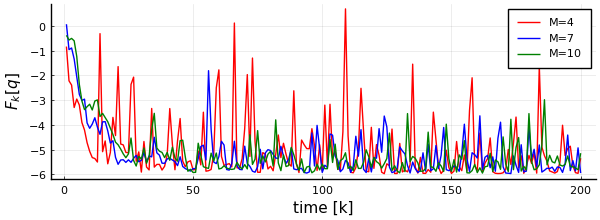

In [86]:
p88 = plot(free_energies[:,1], color="red", label="M="*string(orders[1]), xlabel="time [k]", ylabel=L"$F_k[q]$", size=(600,220), legend=:topright)
plot!(free_energies[:,2], color="blue", label="M="*string(orders[2]))
plot!(free_energies[:,3], color="green", label="M="*string(orders[3]))

In [87]:
savefig(p88, "figures/NARMAX-Fk_deg"*string(deg)*"_vary-model-orders.png")

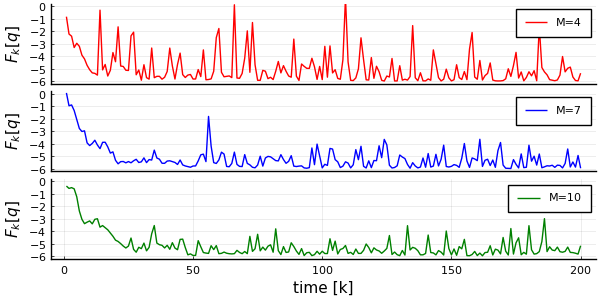

In [99]:
p89a = plot(free_energies[:,1], color="red", label="M="*string(orders[1]), ylabel=L"$F_k[q]$", xticks=:none, legend=:topright, ylims=[-6.,0.])
p89b = plot(free_energies[:,2], color="blue", label="M="*string(orders[2]), ylabel=L"$F_k[q]$", xticks=:none, legend=:topright, ylims=[-6.,0.])
p89c = plot(free_energies[:,3], color="green", label="M="*string(orders[3]), xlabel="time [k]", ylabel=L"$F_k[q]$", legend=:topright, ylims=[-6.,0.])
p89 = plot(p89a, p89b, p89c, layout=(3,1), size=(600,300))

In [100]:
savefig(p89, "figures/NARMAX-Fk_deg"*string(deg)*"_vary-model-orders_subplots.png")

In [76]:
println("FE M"*string(orders[1])*" = "*string(mean(free_energies[:,1])))
println("FE M"*string(orders[2])*" = "*string(mean(free_energies[:,2])))
println("FE M"*string(orders[3])*" = "*string(mean(free_energies[:,3])))

FE M4 = -4.927105768511394
FE M7 = -5.154295954598188
FE M10 = -5.137006093842753


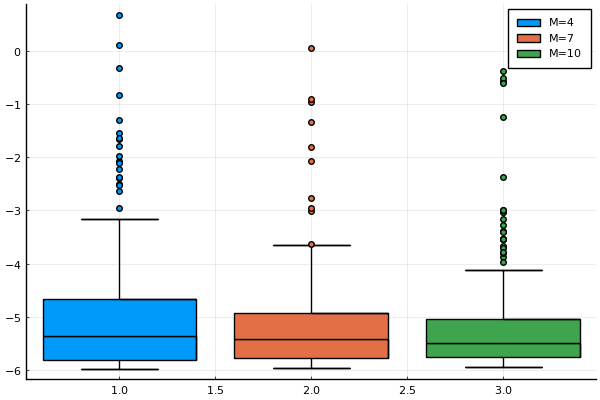

In [77]:
boxplot(free_energies, labels=["M=4" "M=7" "M=10"])

### Experiment: varying polynomial degrees

In [141]:
# Signal lengths
NT = [50, 100, 200, 400, 800, 1600, 3200]
NE = length(NT)

order = 10
deg = [1,2,3]
ND = length(deg)

results = zeros(4, NE, ND)
diffs = zeros(2, NE, ND)
for (j,d) in enumerate(deg)
    for (i,n) in enumerate(NT)

        RMS_FEM = load("results/results-NARMAX_FEM_M"*string(order)*"_degree"*string(d)*"_S"*string(n)*".jld", "RMS")
        RMS_RLS = load("results/results-NARMAX_RLS_M"*string(order)*"_degree"*string(d)*"_S"*string(n)*".jld", "RMS")
        ΔRMS = RMS_FEM .- RMS_RLS

        # Filter infinities and NaNs
        RMS_FEM = filter(!isinf, filter(!isnan, RMS_FEM))
        RMS_RLS = filter(!isinf, filter(!isnan, RMS_RLS))
        ΔRMS = filter(!isinf, filter(!isnan, ΔRMS))

        results[1,i,j] = tmean(RMS_FEM, tr=0.05)
        results[2,i,j] = trimse(RMS_FEM, tr=0.05)
        results[3,i,j] = tmean(RMS_RLS, tr=0.05)
        results[4,i,j] = trimse(RMS_RLS, tr=0.05)
        
        diffs[1,i,j] = tmean(ΔRMS, tr=0.05)
        diffs[2,i,j] = trimse(ΔRMS, tr=0.05)
    end
end

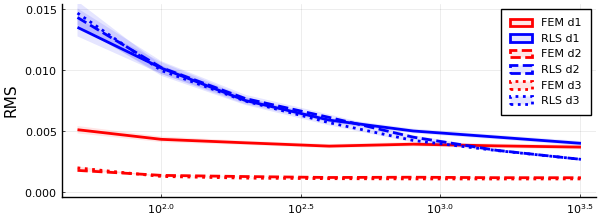

In [144]:
p8 = plot(size=(600,220), legend=:topright)
for (ii,deg) in enumerate(deg)

    plot!(NT, results[1,:,ii], 
          ribbon=[results[2,:,ii] results[2,:,ii]], 
          color="red", 
          label="FEM d"*string(deg), 
          linestyle=styles[ii],
          fillalpha=alpha,
          linewidth=linewidth,
          ylabel="RMS",
          xscale=:log10,
#           yscale=:log10,
          ylims=[0.0, 0.015]
          )
    plot!(NT, results[3,:,ii], 
          ribbon=[results[4,:,ii] results[4,:,ii]], 
          color="blue", 
          linestyle=styles[ii],
          fillalpha=alpha,
          linewidth=linewidth,
          label="RLS d"*string(deg))
end
plot!()

In [143]:
savefig(p8, "figures/NARMAX-RMS_order"*string(order)*"_vary-pol-degree.png")